# Stock Price Movement Prediction - Baseline LSTM Model

This notebook implements a baseline LSTM model using PyTorch to predict next-day stock price movements (Up/Neutral/Down) based on historical data and technical indicators.


## 1. Import Libraries and Setup


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.5.1
Device: cuda


## 2. Configuration


In [5]:
# Configuration
TICKER = 'BAJFINANCE'  # Starting with one stock for baseline
WINDOW_SIZE = 30  # Use 30 days of historical data to predict next day
TEST_SIZE = 0.2  # 20% for testing
VALIDATION_SIZE = 0.1  # 10% for validation (from training set)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
HIDDEN_SIZE = 64  # LSTM hidden units
NUM_LAYERS = 2  # Number of LSTM layers
DROPOUT = 0.2
PATIENCE = 15  # Early stopping patience

print(f"Configuration:")
print(f"  - Ticker: {TICKER}")
print(f"  - Window Size: {WINDOW_SIZE} days")
print(f"  - Test Size: {TEST_SIZE * 100}%")
print(f"  - Validation Size: {VALIDATION_SIZE * 100}%")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Max Epochs: {EPOCHS}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - LSTM Hidden Size: {HIDDEN_SIZE}")
print(f"  - LSTM Layers: {NUM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")


Configuration:
  - Ticker: BAJFINANCE
  - Window Size: 30 days
  - Test Size: 20.0%
  - Validation Size: 10.0%
  - Batch Size: 32
  - Max Epochs: 100
  - Learning Rate: 0.001
  - LSTM Hidden Size: 64
  - LSTM Layers: 2
  - Dropout: 0.2


## 3. Load and Explore Data


In [6]:
# Load the processed data
data_file = f'stock_data_daily_processed/{TICKER}_daily_data.csv'
df = pd.read_csv(data_file, header=[0, 1], index_col=0, parse_dates=True)

print(f"\nLoaded data for {TICKER}:")
print(f"  - Shape: {df.shape}")
print(f"  - Date range: {df.index.min()} to {df.index.max()}")
print(f"  - Total columns: {len(df.columns)}")
print(f"\nColumn names:")
print(df.columns.tolist()[:10], "...")  # Show first 10 columns
print(f"\nFirst few rows:")
df.head()



Loaded data for BAJFINANCE:
  - Shape: (1481, 23)
  - Date range: 2018-01-01 00:00:00 to 2023-12-29 00:00:00
  - Total columns: 23

Column names:
[('Close', 'BAJFINANCE.NS'), ('High', 'BAJFINANCE.NS'), ('Low', 'BAJFINANCE.NS'), ('Open', 'BAJFINANCE.NS'), ('Volume', 'BAJFINANCE.NS'), ('day_of_week', 'BAJFINANCE.NS'), ('month', 'BAJFINANCE.NS'), ('day_of_week_sin', 'BAJFINANCE.NS'), ('day_of_week_cos', 'BAJFINANCE.NS'), ('month_sin', 'BAJFINANCE.NS')] ...

First few rows:


Price,Close,High,Low,Open,Volume,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,...,sma_10,ema_10,rsi_14,macd,macd_signal,macd_hist,bollinger_upper,bollinger_lower,bollinger_mid,target
Ticker,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,...,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,168.066772,171.412230,167.555449,171.363531,5353190,0,1,0.000000,1.000000,0.5,...,NaN,168.066772,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0
2018-01-02,167.969360,169.435134,166.542552,169.435134,5762080,1,1,0.781831,0.623490,0.5,...,NaN,168.049061,NaN,-0.007771,-0.001554,-0.006217,NaN,NaN,NaN,-1
2018-01-03,167.058746,169.303670,166.639962,168.198246,4161360,2,1,0.974928,-0.222521,0.5,...,NaN,167.869004,NaN,-0.086412,-0.018526,-0.067886,NaN,NaN,NaN,1
2018-01-04,170.827866,171.241790,166.932133,168.003465,7301470,3,1,0.433884,-0.900969,0.5,...,NaN,168.406979,NaN,0.153630,0.015905,0.137724,NaN,NaN,NaN,1
2018-01-05,176.720169,177.353235,171.324586,171.996602,9843270,4,1,-0.433884,-0.900969,0.5,...,NaN,169.918468,NaN,0.809987,0.174722,0.635265,NaN,NaN,NaN,1


In [7]:
# Check target distribution
target_col = ('target', f'{TICKER}.NS')
print(f"\nTarget distribution:")
print(df[target_col].value_counts().sort_index())
print(f"\nTarget distribution (%):")
print(df[target_col].value_counts(normalize=True).sort_index() * 100)

# Check for missing values
print(f"\nMissing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0])



Target distribution:
(target, BAJFINANCE.NS)
-1    672
 0     74
 1    735
Name: count, dtype: int64

Target distribution (%):
(target, BAJFINANCE.NS)
-1    45.374747
 0     4.996624
 1    49.628629
Name: proportion, dtype: float64

Missing values per column:
Price            Ticker       
log_return       BAJFINANCE.NS     1
sma_5            BAJFINANCE.NS     4
sma_10           BAJFINANCE.NS     9
rsi_14           BAJFINANCE.NS    13
bollinger_upper  BAJFINANCE.NS    19
bollinger_lower  BAJFINANCE.NS    19
bollinger_mid    BAJFINANCE.NS    19
dtype: int64


## 4. Data Preparation


In [8]:
# Remove rows with NaN values (from technical indicators lookback period)
df_clean = df.dropna()
print(f"After removing NaN values: {df_clean.shape}")

# Separate features and target
# Exclude target column from features
feature_cols = [col for col in df_clean.columns if 'target' not in col[0]]
target_col = ('target', f'{TICKER}.NS')

X = df_clean[feature_cols].values
y = df_clean[target_col].values

# Convert target to class indices: -1 -> 0, 0 -> 1, 1 -> 2
y = (y + 1).astype(int)  # Now: Down=0, Neutral=1, Up=2

print(f"\nFeature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTarget class distribution after mapping:")
print(f"  Down (0): {np.sum(y == 0)}")
print(f"  Neutral (1): {np.sum(y == 1)}")
print(f"  Up (2): {np.sum(y == 2)}")


After removing NaN values: (1462, 23)

Feature shape: (1462, 22)
Target shape: (1462,)
Number of features: 22

Target class distribution after mapping:
  Down (0): 663
  Neutral (1): 73
  Up (2): 726


In [9]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features normalized using StandardScaler")
print(f"  - Mean: ~{X_scaled.mean():.4f}")
print(f"  - Std: ~{X_scaled.std():.4f}")


Features normalized using StandardScaler
  - Mean: ~0.0000
  - Std: ~1.0000


In [10]:
# Create sequences for LSTM
def create_sequences(X, y, window_size):
    """
    Create sequences for LSTM input
    X: features array
    y: target array
    window_size: number of time steps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled, y, WINDOW_SIZE)

print(f"\nSequence creation:")
print(f"  - Input sequence shape: {X_sequences.shape}")
print(f"  - Target sequence shape: {y_sequences.shape}")
print(f"  - Each sample: {WINDOW_SIZE} time steps × {X_sequences.shape[2]} features")



Sequence creation:
  - Input sequence shape: (1432, 30, 22)
  - Target sequence shape: (1432,)
  - Each sample: 30 time steps × 22 features


In [11]:
# Split data: train, validation, test
# First split: test set
test_size = int(len(X_sequences) * TEST_SIZE)
X_temp, X_test = X_sequences[:-test_size], X_sequences[-test_size:]
y_temp, y_test = y_sequences[:-test_size], y_sequences[-test_size:]

# Second split: validation from training
val_size = int(len(X_temp) * VALIDATION_SIZE)
X_train, X_val = X_temp[:-val_size], X_temp[-val_size:]
y_train, y_val = y_temp[:-val_size], y_temp[-val_size:]

print(f"\nData split:")
print(f"  - Training: {X_train.shape[0]} samples ({len(X_train) / len(X_sequences) * 100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]} samples ({len(X_val) / len(X_sequences) * 100:.1f}%)")
print(f"  - Test: {X_test.shape[0]} samples ({len(X_test) / len(X_sequences) * 100:.1f}%)")



Data split:
  - Training: 1032 samples (72.1%)
  - Validation: 114 samples (8.0%)
  - Test: 286 samples (20.0%)


In [12]:
# Create PyTorch datasets
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  - Training batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")



DataLoaders created:
  - Training batches: 33
  - Validation batches: 4
  - Test batches: 9


## 5. Define LSTM Model


In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Take the last time step's output
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.dropout(last_output)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Initialize model
input_size = X_train.shape[2]  # Number of features
num_classes = 3  # Down, Neutral, Up

model = LSTMClassifier(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=DROPOUT
).to(device)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")



Model Architecture:
LSTMClassifier(
  (lstm): LSTM(22, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

Total parameters: 57,987


## 6. Training Setup


In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"Training setup:")
print(f"  - Loss function: CrossEntropyLoss")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  - Scheduler: ReduceLROnPlateau")


Training setup:
  - Loss function: CrossEntropyLoss
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau


In [15]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

print("Training and validation functions defined")


Training and validation functions defined


## 7. Train the Model


In [16]:
# Training loop with early stopping
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model (Val Loss: {best_val_loss:.4f})")

print("\nTraining completed!")


Starting training...

Epoch [1/100]
  Train Loss: 0.9439, Train Acc: 44.57%
  Val Loss: 0.7887, Val Acc: 51.75%
Epoch [10/100]
  Train Loss: 0.8386, Train Acc: 50.68%
  Val Loss: 0.8391, Val Acc: 53.51%

Early stopping triggered at epoch 16

Loaded best model (Val Loss: 0.7887)

Training completed!


## 8. Visualize Training History


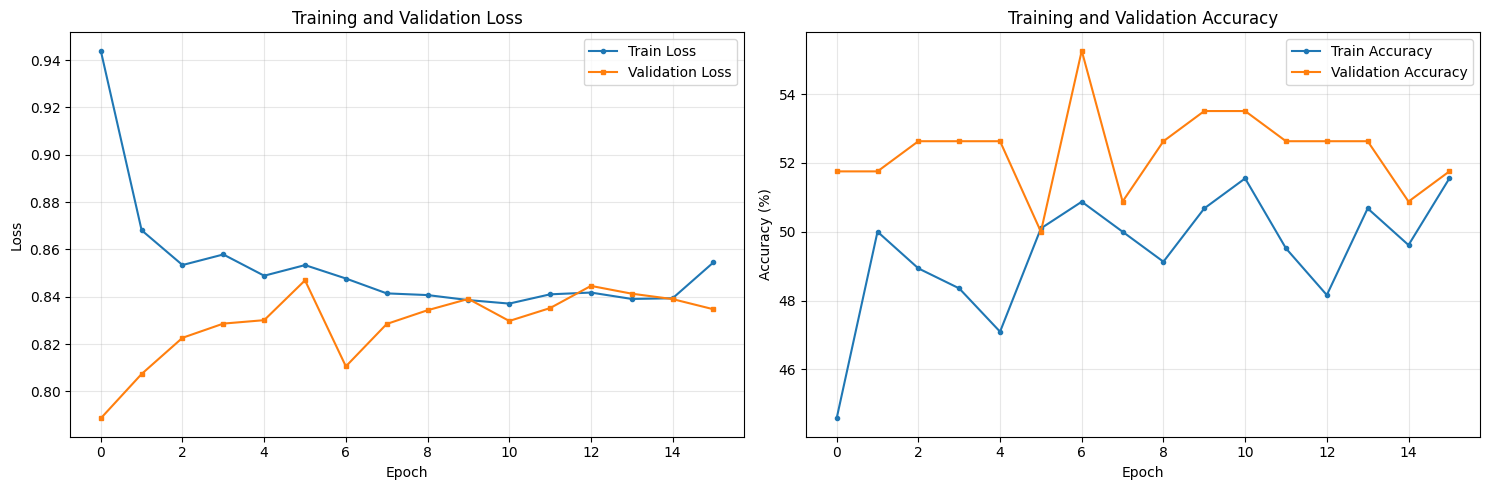

Final Training Accuracy: 51.55%
Final Validation Accuracy: 51.75%


In [17]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', markersize=3)
ax1.plot(val_losses, label='Validation Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o', markersize=3)
ax2.plot(val_accs, label='Validation Accuracy', marker='s', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")


## 9. Evaluate on Test Set


In [18]:
# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"Test Results:")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Test Accuracy: {test_acc:.2f}%")


Test Results:
  - Test Loss: 0.9149
  - Test Accuracy: 41.96%


In [19]:
# Get predictions for detailed metrics
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Classification report
class_names = ['Down', 'Neutral', 'Up']
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_predictions)
print("\nConfusion Matrix:")
print(cm)



Classification Report:
              precision    recall  f1-score   support

        Down       0.38      0.12      0.18       139
     Neutral       0.00      0.00      0.00        19
          Up       0.43      0.80      0.56       128

    accuracy                           0.42       286
   macro avg       0.27      0.31      0.25       286
weighted avg       0.37      0.42      0.34       286


Confusion Matrix:
[[ 17   0 122]
 [  3   0  16]
 [ 25   0 103]]


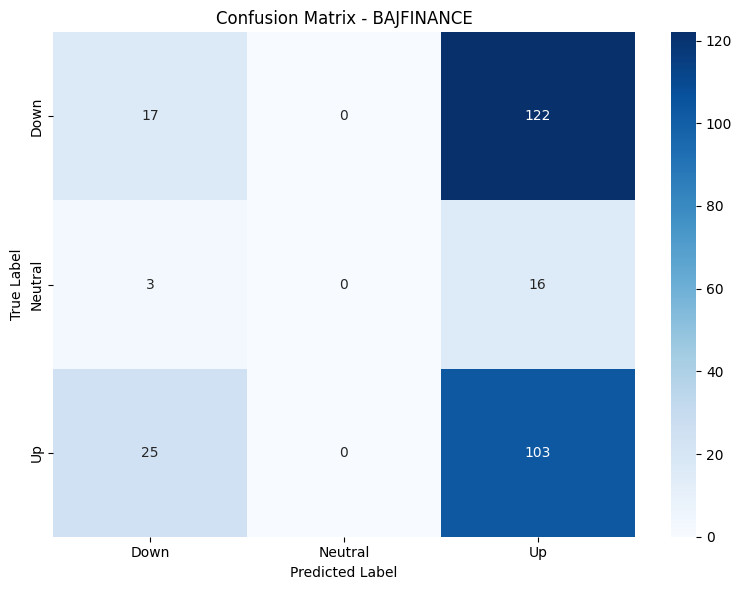


Per-Class Performance:
  Down: 12.23% (17/139 correct)
  Neutral: 0.00% (0/19 correct)
  Up: 80.47% (103/128 correct)


In [20]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {TICKER}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"  {class_name}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()} correct)")


## 10. Save Model


In [ ]:
# Save model and scaler
import os
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model
model_path = f'models/{TICKER}_lstm_baseline.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_size': input_size,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'num_classes': num_classes,
        'dropout': DROPOUT
    },
    'window_size': WINDOW_SIZE,
    'test_accuracy': test_acc,
    'feature_cols': feature_cols
}, model_path)

# Save scaler
scaler_path = f'models/{TICKER}_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"\nBaseline Model Summary:")
print(f"  - Stock: {TICKER}")
print(f"  - Window Size: {WINDOW_SIZE}")
print(f"  - Test Accuracy: {test_acc:.2f}%")
print(f"  - Number of Features: {input_size}")
